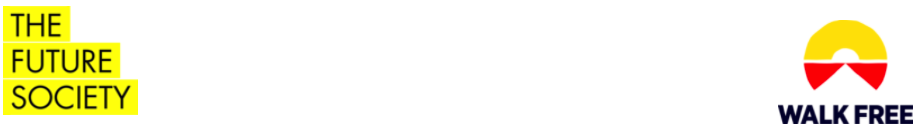

#*Project AIMS (AI against Modern Slavery)*
---




 
##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1ZoNqDMx-BnUvOdCqs6VJRjb3xt-A0DOX/view?usp=sharing).

#  Statement Signed 
 
## Was the company’s Modern Slavery Act statement signed by an appropriate person?
 
The MSA requires that the statements are discussed at the senior management level and signed by an appropriate senior member of the company (depending on the type of company it is).
 
Each statement should be signed by an appropriate senior member of the company, and these signatures are usually found at the end of the document. This metric asks who signed the company's statement. Along with the signature, the title and name of the individual who has signed should be displayed.
 
 
For more information, please read WikiRate’s research on [MSA statement signed](https://wikirate.org/Business_Human_Rights_Resource_Centre+MSA_statement_signed) or [the Home Office Guidance, page 13.](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf)



## Labelled dataset
When building the labelled dataset, the possible label selected by the annotators for this metric are as follows: Signed by CEO, Signed by Director, Signed by Managing Director, Signed by other role (where there is a signature by a named individual whose role is not covered by one of the above options), and Signed - no title (where there is a signature by a named individual but no description of their role). The annotators also added a Comment with the part of the text of the statement indicating this information. If any of those labels are found for a statement, for the purpose of this task, the statement was labelled ‘Yes/1’. If the annotators labelled the statement either Not signed - but individual with title named - if there is no signature, but a specific individual and their title are given, choose this option or Not signed - where no individual has signed the statement, the statement was relabelled with ‘No/0’.
 




## Setup

In [ ]:
#!pip install snorkel
#!pip install -U sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


In [ ]:
import torch
import nltk
import nltk.data
import pandas as pd
from sklearn.model_selection import train_test_split
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
import re
from utils import evaluation_rb

nltk.download('punkt')


## Read data from csv

 
### 🗄️ You can access the data used in this notebook [here ](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).


In [ ]:
metric = 'Business & Human Rights Resource Centre+Modern Slavery Statement'

In [ ]:
df = pd.read_csv('labeled-dataset.csv', dtype=object,  index_col=0)
df.fillna(-1)
df[metric] = [1 if "Yes" in str(value) else 0 for value in df[metric]]
print(df[metric].value_counts())


1    1899
0     850
Name: Business & Human Rights Resource Centre+Modern Slavery Statement, dtype: int64


##Regular expression labeling function

In [ ]:
keywords = [r"(s|S)igned\s*on\s*(\w)*\s*behalf\s*\w*","( s|S)igned\s*by\s*\w*","is\s*signed\s*below","Signature"]
regex_exp = re.compile( '|'.join( keywords))

ABSTAIN = -1
NO = 0
YES = 1


@labeling_function()
def lf_signed_ex_search(x):
    """
    :param x: string representation of a document
    :return: binary label
    """
    x_lower = str(x.TEXT).strip().lower()
    if x_lower == ABSTAIN :
        return ABSTAIN
    return YES if re.search(regex_exp, x_lower)!= None else NO

lfs = [lf_signed_ex_search]
applier = PandasLFApplier(lfs)
L_train = applier.apply(df=df)

100%|██████████| 2749/2749 [00:00<00:00, 2861.57it/s]


In [ ]:
coverage = (L_train != NO).mean(axis=0)
print("Signature coverage is", coverage)

Signature coverage is [0.07057112]


### Keyword labeling function

In [ ]:
@labeling_function()
def lf_signed_keyword_search(x):
    """
    :param x: string representation of a document
    :return: binary label
    """
    sign_marks = ['signed on behalf of','signed on its behalf','signed on their behalf','signed by the',
    'is signed below','signed by the','signed by a','Signature','Signed by']
#     result = NO
    x_lower = str(x.TEXT).strip().lower()
    if x_lower == ABSTAIN :
        return ABSTAIN
    for smarks in sign_marks:
        if smarks in str(x.TEXT):
            return YES
    return NO
    
    
lfs = [lf_signed_keyword_search]
applier = PandasLFApplier(lfs)
L_train1 = applier.apply(df=df)

100%|██████████| 2749/2749 [00:00<00:00, 6120.41it/s]


In [ ]:
coverage = (L_train1 != NO).mean(axis=0)
print("Signature coverage is", coverage)

Signature coverage is [0.07384503]


### Sentence cosinsimilarity labeling function

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

#sentence segmentation
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
threshold = 0.8

# sign_marks embedding
sign_marks = ['signed on behalf of','signed on its behalf','signed on their behalf','signed by the',
    'is signed below','signed by the','signed by a','Signature','Signed by']
embeddings2 = model.encode(sign_marks, convert_to_tensor=True)

@labeling_function()
def lf_signed_cosinsimilarity_search(x):
    """
    :param x: string representation of a document
    :return: binary label
    """
    if str(x.TEXT).strip().lower() !='' or str(x.TEXT).strip().lower() !='nan':
        list_sentences = sent_detector.tokenize(str(x.TEXT).strip().lower())
        last_5_sentenct = list_sentences[-10:]
        embeddings1 = model.encode(last_5_sentenct, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
        if cosine_scores[cosine_scores>threshold].size()[0]>0 :
            return YES
        return NO
    else :
        return ABSTAIN


lfs = [lf_signed_cosinsimilarity_search]
applier = PandasLFApplier(lfs)
L_train2 = applier.apply(df=df)


100%|██████████| 2749/2749 [30:37<00:00,  1.50it/s]


### Generate the training dataset

In [ ]:
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier




# Define the set of labeling functions (LFs)
lfs = [lf_signed_ex_search,lf_signed_keyword_search,lf_signed_cosinsimilarity_search]

# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs)
L_train = applier.apply(df)

# Train the label model and compute the training labels
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)

100%|██████████| 2749/2749 [30:28<00:00,  1.50it/s]


In [ ]:
df["label"] = label_model.predict(L=L_train, tie_break_policy="abstain")

In [ ]:
coverage = (df["label"] != NO).mean(axis=0)
print("Signature coverage is", coverage)

Signature coverage is 0.10440160058202982


Evaluation of the rule-based model


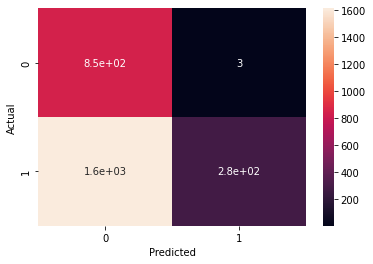

Confusion Matrix:
 [[ 847    3]
 [1615  284]]
Accuracy Score: 0.411422335394689
Precision Score: 0.78995077614519
Recall Score: 0.411422335394689
F1 Score: 0.33764266273874805


In [ ]:
evaluation_rb.main(df[metric], df['label'])

## Adding labels and matchsentence to the dataset

In [ ]:
#sentence segmentation
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')


def addRexLabelMatchSentence2Dataset(msd_df, label):
    #copy of the dataset
    msd_df_copy= msd_df.copy()

    msd_df_copy["Signed_Predicted_label"] = label.reshape(-1) 
    msd_df_copy = msd_df_copy.reset_index(drop=True)
    msd_df_copy["Signed_Found_element"] =''
    msd_df_copy["Signed_Sentence"] =''
    for idx in msd_df_copy.index:
        text = str(msd_df_copy.at[idx,'Text'])
        if L_train[idx][0] == 1:
            list_sentences = sent_detector.tokenize(text.strip().lower())
            signed_found_element = ''
            signed_sentence = ''
            for i,s in enumerate(list_sentences):
                if re.search(regex_exp, s):
                    match_obj = re.search(regex_exp, s)
                    signed_found_element = match_obj.group(0)
                    signed_sentence= s
                    break
            msd_df_copy.at[idx,'Signed_Found_element'] =signed_found_element
            msd_df_copy.at[idx,'Signed_Sentence']=signed_sentence
        else:
            msd_df_copy.at[idx,'Signed_Sentence'] =str(text[-100:])
    return msd_df_copy

lfs = [lf_signed_ex_search]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df=msd_df)

result = addRexLabelMatchSentence2Dataset(msd_df,L_train)
result.head()
# result.to_csv("Regx_labeled-signed-dataset.csv")   

In [ ]:
result.to_csv("Regx_labeled-signed-dataset_training.csv")  #add text(-100 of text) to signed_sentence field

In [ ]:
result[result['Signed_Predicted_label'] == 1].to_csv("Regx_labeled-signed-dataset1.csv")  

In [ ]:
df_train_bi = result[result.Signed_Predicted_label == ABSTAIN]
df_train_bi.head()

,Company,Is Publisher,Statement ID,URL,Override URL,Companies House Number,Industry,HQ,Is Also Covered,UK Modern Slavery Act,California Transparency in Supply Chains Act,Australia Modern Slavery Act,Period Covered,Text,Signed_Predicted_label,Signed_Found_element,Signed_Sentence


In [ ]:
coverage = (result['Signed_Predicted_label'] != NO).mean(axis=0)
print("Signed coverage is", coverage)

Signed coverage is 0.07921314705985853
